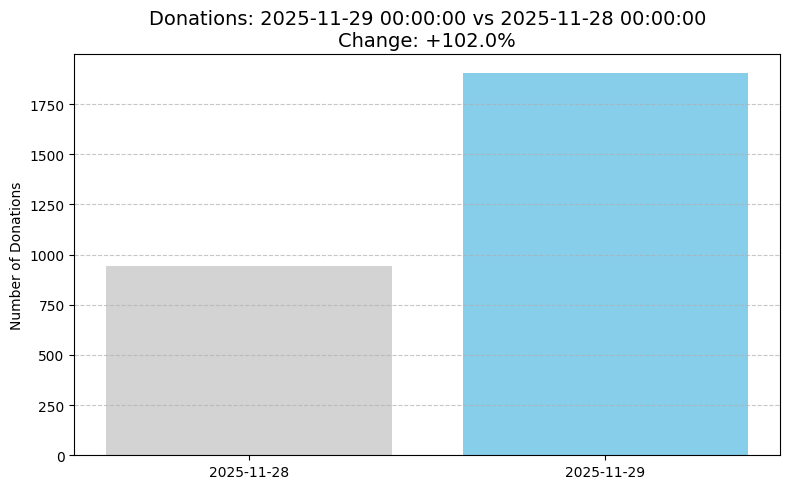

  visit_date  donation_count
1 2025-11-28             942
0 2025-11-29            1903


In [3]:

import duckdb
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

# Connect to DuckDB
conn = duckdb.connect("../donations.duckdb")

# Find latest available date in complete_donor
latest_date = conn.execute("SELECT MAX(visit_date) FROM complete_donor").fetchone()[0]

# Get yesterday and today (or latest two dates)
query = """
SELECT visit_date, COUNT(*) AS donation_count
FROM complete_donor
WHERE visit_date >= CURRENT_DATE - INTERVAL '1 day'
GROUP BY visit_date
ORDER BY visit_date
"""

recent_df = conn.execute(query).fetchdf()

# If no data for today, fallback to last two available dates
if recent_df.empty or len(recent_df) < 2:
    recent_df = conn.execute("""
        SELECT visit_date, COUNT(*) AS donation_count
        FROM complete_donor
        GROUP BY visit_date
        ORDER BY visit_date DESC
        LIMIT 2
    """).fetchdf()

# Sort by date
recent_df = recent_df.sort_values('visit_date')

# Calculate percentage change
if len(recent_df) >= 2:
    change = ((recent_df.iloc[-1]['donation_count'] - recent_df.iloc[-2]['donation_count']) /
              recent_df.iloc[-2]['donation_count']) * 100
else:
    change = 0

# Plot
plt.figure(figsize=(8, 5))
plt.bar(recent_df['visit_date'].astype(str), recent_df['donation_count'], color=['lightgray', 'skyblue'])
plt.title(f"Donations: {recent_df.iloc[-1]['visit_date']} vs {recent_df.iloc[-2]['visit_date']}\nChange: {change:+.1f}%", fontsize=14)
plt.ylabel('Number of Donations')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('daily_donation_comparison.png')
plt.show()

print(recent_df)


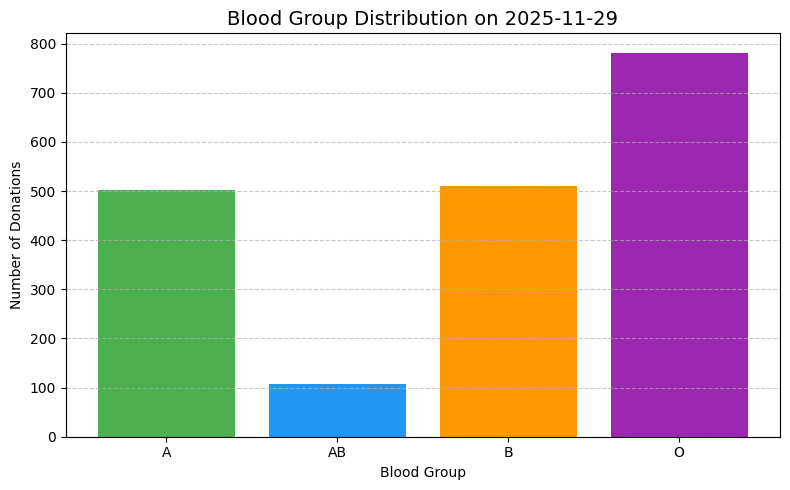

  blood_group  donation_count
0           A             503
1          AB             108
2           B             510
3           O             782


In [2]:

import duckdb
import pandas as pd
import matplotlib.pyplot as plt

# Connect to DuckDB database
conn = duckdb.connect("../donations.duckdb")

# Find latest available date in complete_donor
latest_date = conn.execute("SELECT MAX(visit_date) FROM complete_donor").fetchone()[0]

# Query blood group distribution for latest date
query = f"""
SELECT blood_group, COUNT(*) AS donation_count
FROM complete_donor
WHERE visit_date = '{latest_date}' AND blood_group IS NOT NULL
GROUP BY blood_group
ORDER BY blood_group
"""

blood_group_df = conn.execute(query).fetchdf()

# If no data for that date, fallback or simulate
if blood_group_df.empty:
    blood_group_df = pd.DataFrame({
        'blood_group': ['A', 'B', 'AB', 'O'],
        'donation_count': [120, 80, 40, 160]  # Example values
    })

# Plot blood group distribution
plt.figure(figsize=(8, 5))
plt.bar(blood_group_df['blood_group'], blood_group_df['donation_count'],
        color=['#4CAF50', '#2196F3', '#FF9800', '#9C27B0'])
plt.title(f"Blood Group Distribution on {latest_date}", fontsize=14)
plt.xlabel('Blood Group')
plt.ylabel('Number of Donations')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('blood_group_distribution_daily.png')
plt.show()

print(blood_group_df)


Blood Group Distribution Today
- Pie chart or bar chart.
- Insight: “O+ donors were the largest group today—every blood type matters!”

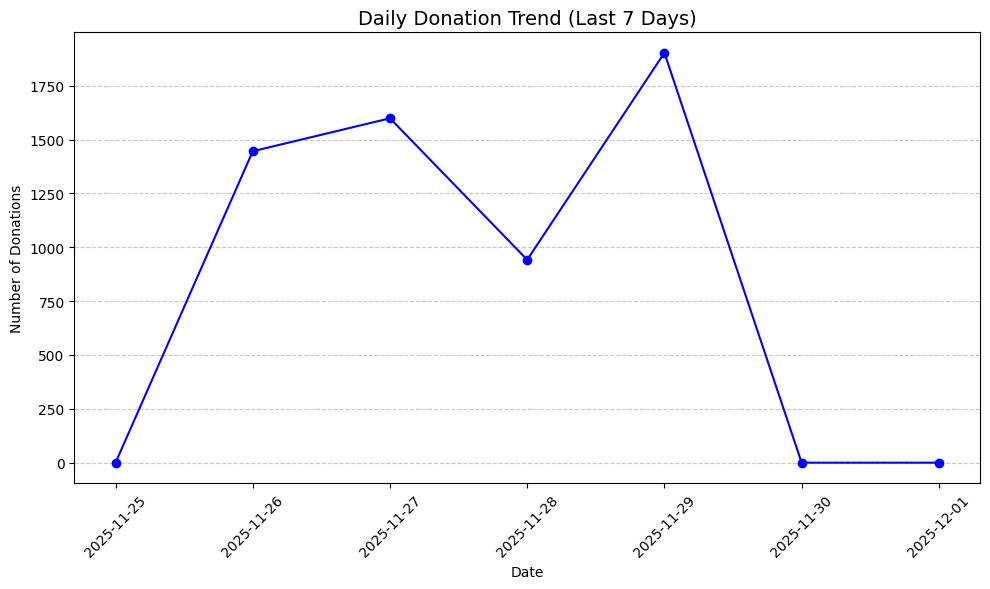

   visit_date  donation_count
0  2025-11-25             0.0
1  2025-11-26          1446.0
2  2025-11-27          1599.0
3  2025-11-28           942.0
4  2025-11-29          1903.0
5  2025-11-30             0.0
6  2025-12-01             0.0
Insight: Donations trend is mixed or stable.


In [1]:

import duckdb
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

# Connect to DuckDB database
conn = duckdb.connect("../donations.duckdb")

# Query donation counts for the last 7 days
query = """
SELECT visit_date, COUNT(*) AS donation_count
FROM complete_donor
WHERE visit_date >= CURRENT_DATE - INTERVAL '7 day'
GROUP BY visit_date
ORDER BY visit_date
"""

df = conn.execute(query).fetchdf()

# Ensure all 7 days are present (fill missing days with 0)
end_date = datetime.now().date()
start_date = end_date - timedelta(days=6)
all_dates = pd.date_range(start=start_date, end=end_date)

# Convert visit_date to datetime
if not df.empty:
    df['visit_date'] = pd.to_datetime(df['visit_date']).dt.date
else:
    df = pd.DataFrame(columns=['visit_date', 'donation_count'])

# Reindex with all dates
trend_df = pd.DataFrame({'visit_date': all_dates.date})
trend_df = trend_df.merge(df, on='visit_date', how='left').fillna(0)

# Check if donations have increased for 3 consecutive days
insight_msg = ""
if len(trend_df) >= 3:
    last_three = trend_df['donation_count'].iloc[-3:]
    if last_three.is_monotonic_increasing:
        insight_msg = "Donations have been rising for 3 days straight—keep the momentum going!"

# Plot line chart
plt.figure(figsize=(10, 6))
plt.plot(trend_df['visit_date'], trend_df['donation_count'], marker='o', color='blue')
plt.title("Daily Donation Trend (Last 7 Days)", fontsize=14)
plt.xlabel("Date")
plt.ylabel("Number of Donations")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('daily_donation_trend.png')
plt.show()

# Print data and insight
print(trend_df)
if insight_msg:
    print("Insight:", insight_msg)
else:
    print("Insight: Donations trend is mixed or stable.")


In [4]:
conn.close()